## Initial Tests of DMC on 1D system

In [5]:
using Pkg

# Activate project and ensure dependencies are available (first run may take time).
Pkg.activate("/Users/ismaelchona/PersonalProjects/DMC_project")
Pkg.instantiate()

# Now bring them into scope (safe if they were loaded above)
using System1D
using Plots
using StatsBase
using KernelDensity
using Statistics
using Random
using Printf

# Helpers for snapshot -> 1D x and tau -> snapshot index
xs_from_snapshot(snap) = [R[1] for R in snap]

function snap_index_from_tau(tau::Real, dt::Real, nsnaps::Int)
    return clamp(Int(round(tau/dt)) + 1, 1, nsnaps)
end

# Notebook convenience RNG (fixed seed for reproducibility).
const NB_RNG = MersenneTwister(42)

@info "Preamble complete - if you installed packages, restart the kernel and re-run this cell."


  Activating project at `~/PersonalProjects/DMC_project`
┌ Info: Preamble complete — if you installed packages, restart the kernel and re-run this cell.
└ @ Main /Users/ismaelchona/PersonalProjects/DMC_project/Notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:28


# 1D harmonic oscillator example
We aim to solve the Harmonic oscillator in 1D we use atomic units $$\hbar = \omega = 1 $$
$$ \displaystyle H = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2} x^2  $$
This script initialiases the simulation

In [ ]:
# System setup
# Harmonic oscillator potential and Hamiltonian.
H = Hamiltonian(1, 0.5, R -> 0.5 * sum(R .^ 2))   # N=1, D=0.5, V(R)= 0.5 * x^2 (works for vector R)

# Initialize walkers uniformly in [-1, 1].
N = 10^5
W = [Walker([2*rand(NB_RNG) - 1]) for _ in 1:N]

# DMC params: dt, nsteps, nequil, targetN, ET0, pop_gain, branch_cap, nblocks.
p = DMCParams(0.005, 1000, 0, 2*10^5 , 0.5, 0.1, 100, 100)

# Build the simulation (no importance sampling here).
sim = DMCSim(H, p, W, NB_RNG)

# Run simulation.
sim = System1D.run_simulation!(sim)

# Extract histories for plotting.
ET_history = sim.ET_history
population_history = sim.population_history
energy_mean_history = sim.energy_mean_history
walker_positions_history = sim.walker_positions_history


1001-element Vector{Vector{Vector{Float64}}}:
 [[0.42164773468689276], [-0.8710294978033466], [-0.04431471786617003], [-0.6445813888409351], [-0.8929602250340536], [-0.3938139474124114], [-0.10484516188425008], [-0.712818283744578], [-0.5825445213636287], [-0.07472414765000535]  …  [0.19264078074825397], [-0.9799837362711883], [0.8955983599306463], [0.72416141970798], [0.27926236240428404], [-0.3105637477043812], [0.0798416576395562], [-0.5794830162530267], [-0.7724658949047418], [-0.4333079488746261]]
 [[0.37622923463685554], [-0.9459161467269598], [0.059530133876054894], [-0.6383034614475179], [-0.8637950942864501], [-0.46383729925555317], [0.04983579437897054], [-0.7067173217736861], [-0.6131728243831828], [-0.22957827136613687]  …  [0.19405591656857332], [-1.039621598202516], [0.8774257737951411], [0.7450830809873303], [0.31031857162987053], [-0.27848081661284707], [0.09038580812993297], [-0.5385919193485295], [-0.8059616465942829], [-0.29935998268770825]]
 [[0.44249800396439926], 

Now we can plot the results

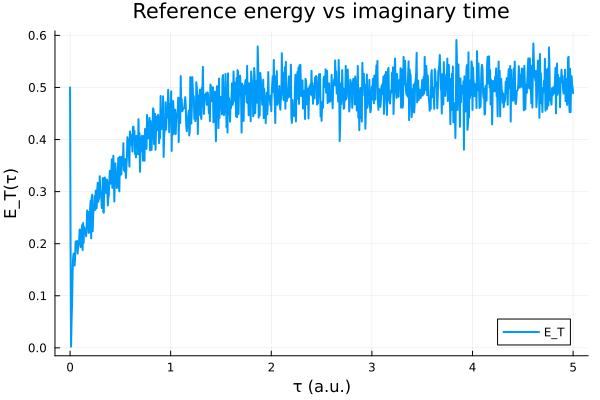

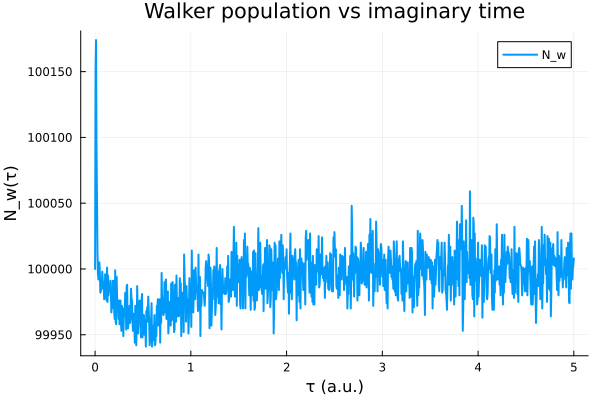

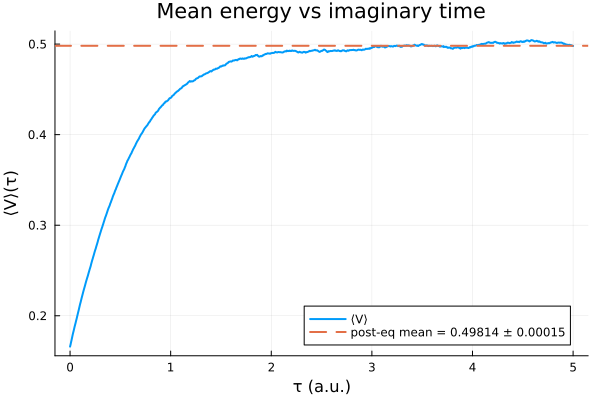

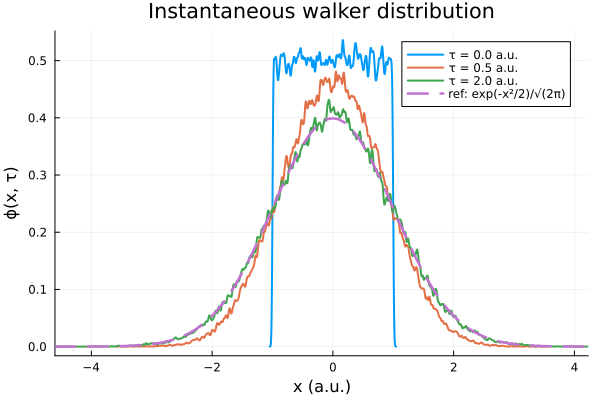

Reported energy (post-eq naive SEM, nequil=500):  E = 0.49814 ± 0.00015 (a.u.)


In [11]:
# Analysis and plotting
# Create output directory for figures.
figdir = joinpath(pwd(), "figures")
mkpath(figdir)

# Post-equilibration window and snapshot times.
nequil = 500
taus   = [0.0, 0.5, 2.0]

dt = sim.params.dt
nsnaps = length(walker_positions_history)

# Time axis for time-series plots.
t = dt .* (0:(length(ET_history)-1))   # tau axis for time-series

# Compute mean for points after nequil.
start_idx = min(nequil + 1, length(energy_mean_history))
postE = energy_mean_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

# Significant-figure formatting for reporting.
p10 = isfinite(SEM) && SEM>0 ? floor(Int, log10(abs(SEM))) : 0
lead = isfinite(SEM) && SEM>0 ? SEM / 10.0^p10 : 1.0
sigunc = (lead < 1.5) ? 2 : 1
decimals = isfinite(SEM) && SEM>0 ? max(0, -p10 + (sigunc - 1)) : 6

println(@sprintf("Reported energy (post-eq naive SEM, nequil=%d):  E = %.*f ± %.*f (a.u.)",
                 nequil, decimals, Ebar, decimals, SEM))

# ET vs tau.
p1 = plot(t, ET_history, lw=2, label="E_T",
          xlabel="τ (a.u.)", ylabel="E_T(τ)",
          title="Reference energy vs imaginary time", legend=:bottomright)
savefig(p1, joinpath(figdir, "ET_vs_tau.png"))
display(p1)

# Population vs tau.
p2 = plot(t, population_history, lw=2, label="N_w",
          xlabel="τ (a.u.)", ylabel="N_w(τ)",
          title="Walker population vs imaginary time", legend=:topright)
savefig(p2, joinpath(figdir, "population_vs_tau.png"))
display(p2)

# Mean energy vs tau + horizontal mean line.
p3 = plot(t, energy_mean_history, lw=2, label="⟨V⟩",
          xlabel="τ (a.u.)", ylabel="⟨V⟩(τ)",
          title="Mean energy vs imaginary time", legend=:bottomright)
hline!(p3, [Ebar], ls=:dash, lw=2, label=@sprintf("post-eq mean = %.*f ± %.*f", decimals, Ebar, decimals, SEM))
savefig(p3, joinpath(figdir, "mean_energy_vs_tau.png"))
display(p3)

# Overlay KDE PDFs at selected tau + reference Gaussian.
snap_index(τ) = clamp(Int(round(τ/dt)) + 1, 1, nsnaps)
xs(snap) = [R[1] for R in snap]

idxs = snap_index.(taus)
xs_list = [xs(walker_positions_history[i]) for i in idxs]

xmin = minimum(minimum.(xs_list))
xmax = maximum(maximum.(xs_list))

p_pdf = plot(xlabel="x (a.u.)", ylabel="ϕ(x, τ)",
             title="Instantaneous walker distribution", xlims=(xmin, xmax),
             legend=:topright)

for (xvals, τ) in zip(xs_list, taus)
    k = kde(xvals; bandwidth = 0.012)
    plot!(p_pdf, k.x, k.density, lw=2, label="τ = $(τ) a.u.")
end

xgrid = range(xmin, xmax; length=800)
gauss = @. exp(-xgrid^2 / 2) / sqrt(2π)
plot!(p_pdf, xgrid, gauss, lw=2.5, ls=:dash, label="ref: exp(-x²/2)/√(2π)")

savefig(p_pdf, joinpath(figdir, "pdf_overlay_vs_tau.png"))
display(p_pdf)


In [7]:
# Importance sampling

# System setup (same as before)
H = Hamiltonian(1, 0.5, R -> 0.5 * sum(R .^ 2))   # N=1, D=0.5, V(R)= 0.5 * x^2
N = 10^5
W = [Walker([2*rand(NB_RNG) - 1]) for _ in 1:N]
p = DMCParams(0.005, 1000, 0, 2*10^5 , 0.5, 0.1, 100, 100)

alpha = 1.0  # for D=0.5 and V=0.5*x^2
trial = TrialWF(
    R -> -0.5 * alpha * R[1]^2,   # log|psi_T|
    R -> [-alpha * R[1]],         # grad log|psi_T|
    R -> -alpha                   # lapl log|psi_T|
)

guiding = ImportanceGuiding(trial, H)
sim_is = DMCSim(H, p, W, guiding, NB_RNG)

sim_is = System1D.run_simulation!(sim_is)

# Analysis and plotting for importance sampling
ET_history_is = sim_is.ET_history
population_history_is = sim_is.population_history
energy_mean_history_is = sim_is.energy_mean_history
walker_positions_history_is = sim_is.walker_positions_history

figdir = joinpath(pwd(), "figures")
mkpath(figdir)
nequil = 500
taus   = [0.0, 0.5, 2.0]

dt = sim_is.params.dt
nsnaps = length(walker_positions_history_is)

t_is = dt .* (0:(length(ET_history_is)-1))   # τ axis for time-series

# compute mean for points after nequil
start_idx = min(nequil + 1, length(energy_mean_history_is))
postE = energy_mean_history_is[start_idx:end]

Ē = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

# sig fig formatting
p10 = isfinite(SEM) && SEM>0 ? floor(Int, log10(abs(SEM))) : 0
lead = isfinite(SEM) && SEM>0 ? SEM / 10.0^p10 : 1.0
sigunc = (lead < 1.5) ? 2 : 1
decimals = isfinite(SEM) && SEM>0 ? max(0, -p10 + (sigunc - 1)) : 6

println(@sprintf("Reported IS energy (post-eq naive SEM, nequil=%d):  E = %.*f ± %.*f (a.u.)",
                 nequil, decimals, Ē, decimals, SEM))

# ET vs τ
p1_is = plot(t_is, ET_history_is, lw=2, label="E_T",
             xlabel="τ (a.u.)", ylabel="E_T(τ)",
             title="IS reference energy vs imaginary time", legend=:bottomright)
savefig(p1_is, joinpath(figdir, "IS_ET_vs_tau.png"))
display(p1_is)

# population vs τ
p2_is = plot(t_is, population_history_is, lw=2, label="N_w",
             xlabel="τ (a.u.)", ylabel="N_w(τ)",
             title="IS walker population vs imaginary time", legend=:topright)
savefig(p2_is, joinpath(figdir, "IS_population_vs_tau.png"))
display(p2_is)

# mean energy vs τ + horizontal mean line
p3_is = plot(t_is, energy_mean_history_is, lw=2, label="⟨E_L⟩",
             xlabel="τ (a.u.)", ylabel="⟨E_L⟩(τ)",
             title="IS mean energy vs imaginary time", legend=:bottomright)
hline!(p3_is, [Ē], ls=:dash, lw=2, label=@sprintf("post-eq mean = %.*f ± %.*f", decimals, Ē, decimals, SEM))
savefig(p3_is, joinpath(figdir, "IS_mean_energy_vs_tau.png"))
display(p3_is)

# overlay KDE PDFs at selected τ + reference Gaussian
snap_index(τ) = clamp(Int(round(τ/dt)) + 1, 1, nsnaps)
xs(snap) = [R[1] for R in snap]

idxs = snap_index.(taus)
xs_list = [xs(walker_positions_history_is[i]) for i in idxs]

xmin = minimum(minimum.(xs_list))
xmax = maximum(maximum.(xs_list))

p_pdf_is = plot(xlabel="x (a.u.)", ylabel="ϕ(x, τ)",
                title="IS instantaneous walker distribution", xlims=(xmin, xmax),
                legend=:topright)

for (xvals, τ) in zip(xs_list, taus)
    k = kde(xvals; bandwidth = 0.012)
    plot!(p_pdf_is, k.x, k.density, lw=2, label="τ = $(τ) a.u.")
end

xgrid = range(xmin, xmax; length=800)
gauss = @. exp(-xgrid^2 / 2) / sqrt(2π)
plot!(p_pdf_is, xgrid, gauss, lw=2.5, ls=:dash, label="ref: exp(-x²/2)/√(2π)")

savefig(p_pdf_is, joinpath(figdir, "IS_pdf_overlay_vs_tau.png"))
display(p_pdf_is)


UndefVarError: UndefVarError: `TrialWF` not defined in `Main`
Suggestion: check for spelling errors or missing imports.